In [2]:
import matplotlib.pyplot as plt
import networkx as nx
import math
import random
import operator as op
from functools import reduce
from tqdm import tqdm
import copy
import pickle
from scipy import io
import networkx as nx

In [3]:
import numpy as np

# Specify the file path
file_path = '/Users/asalrangraziasl/Documents/ Projects_Master/ Inference/FCth.txt'

# Load the data into a NumPy array
data = np.loadtxt(file_path)

# Now, 'data' contains your dataset as a NumPy array

In [4]:
data

array([[1.        , 0.29007275, 0.33406276, ..., 0.27619268, 0.38820639,
        0.24870905],
       [0.29007275, 1.        , 0.6728313 , ..., 0.20622525, 0.31493987,
        0.20340271],
       [0.33406276, 0.6728313 , 1.        , ..., 0.18990944, 0.34645661,
        0.17841752],
       ...,
       [0.27619268, 0.20622525, 0.18990944, ..., 1.        , 0.4226791 ,
        0.48421177],
       [0.38820639, 0.31493987, 0.34645661, ..., 0.4226791 , 1.        ,
        0.45591268],
       [0.24870905, 0.20340271, 0.17841752, ..., 0.48421177, 0.45591268,
        1.        ]])

In [5]:
np.min(data)

-0.0011110186433460477

Average connectivity strength: 0.30562303109507366
Maximum connectivity strength: 1.0
Minimum connectivity strength: -0.0011110186433460477


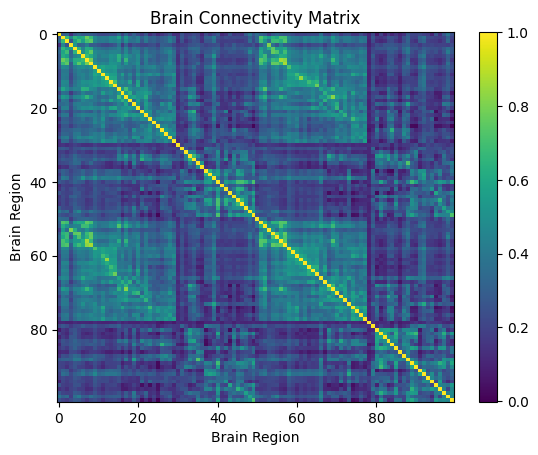

In [6]:
# Example: Calculate the average connectivity strength
average_strength = np.mean(data)
print("Average connectivity strength:", average_strength)

# Example: Calculate the maximum and minimum connectivity strengths
max_strength = np.max(data)
min_strength = np.min(data)
print("Maximum connectivity strength:", max_strength)
print("Minimum connectivity strength:", min_strength)

# Example: Visualize the connectivity matrix (optional)
import matplotlib.pyplot as plt

plt.imshow(data, cmap='viridis', origin='upper', aspect='auto')
plt.colorbar()
plt.title("Brain Connectivity Matrix")
plt.xlabel("Brain Region")
plt.ylabel("Brain Region")
plt.show()

In [7]:
# Set a threshold value (adjust as needed)
threshold = 0.5

# Create a binary connectivity matrix by applying the threshold
A_T = (data > threshold).astype('float64')


In [8]:
A_T

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [9]:
type(A_T)
print(A_T.shape)
print(A_T.dtype)

(100, 100)
float64


### Partitioning

In this part we are partitioning the data then defining some function to use in definition of R and H formula.


In [10]:
#The purpose of this partitioning appears to be part of the Metropolis-Hastings algorithm.
# The binomial coefficien: C(n, r) = n! / (r! * (n - r)!)
def ncr(n, r):  #n choose r
    r = min(r, n-r)
    numer = reduce(op.mul, range(n, n-r, -1), 1)
    denom = reduce(op.mul, range(1, r+1), 1)
    return numer // denom  # or / in Python 2

def index_2d(myList, v): #return the exact index
    for i, x in enumerate(myList):
        if v in x:
            return (i, x.index(v))

def l_ij(alpha,beta, A_T,part):       #number of links between group i and j
    link_num = 0
    for a in part[alpha]:
        for b in part[beta]:
            if A_T[a, b] == 1:
                link_num += 1
    return(link_num)


def r_ij(alpha,beta, part):       #maximum possible number of links between group i and j
    return(len(part[alpha]) * len(part[beta]))

In [11]:
# just example of function index_2d
#myList = [
#    [1, 2, 3],
#    [4, 5, 6],
#   [7, 8, 9]
#]

#result = index_2d(myList, 1)
#print(result)  # Output: (1, 1) :5

#### We use the link reliability to identify missing and spurious interactions in network observations
Here we are defining the 3 and 4 formula(R,H)

In [12]:
def R(i, j, A_T, all_part):   #all_part is a list containing all different partitions
    big_sum= 0
    Z=0
    for part in all_part:

        # define : (l(sigma_i,sigma_j) + 1) / (r(sigma_i,sigma_j) + 2) inside R formula
        sigma_i = index_2d(part, i)[0]
        sigma_j = index_2d(part, j)[0]
        l = l_ij(sigma_i , sigma_j , A_T, part)
        r = r_ij(sigma_i , sigma_j , part)
        parantez = ((l + 1)/(r+2))

        gooz_list = [[x,y] for x in range(len(part)) for y in range(len(part)) if len(part[x])<len(part[y])]
        pair_list=[]
        for x in gooz_list:
            if x not in pair_list: pair_list.append(x)

        # H(p) formula
        H_P = 0
        for pair in pair_list:
            alpha, beta = pair
            l = l_ij(alpha, beta, A_T, part)
            r = r_ij(alpha, beta, part)
            h_p = math.log(r+1) + math.log(ncr(r, l))
            H_P += h_p
        # print('Pair:',pair,',l:',l,',r:',r,',h_p:',h_p,',H_P:',H_P)

        Z += np.exp(-H_P)
        # print(Z)
        big_sum += parantez* np.exp(-H_P)
        R_ij = big_sum/Z
        # print('reliability of i={} and j={}:'.format(i, j), round(R_ij,4))
    return(round(R_ij,5))


In [13]:
# I also define H(P) seperatly because I need it in metropolis function
def H(P):
    pair_list=[]
    H_P=0
    for i in range(len(P)):
        for j in range(len(P)):
            if i<j:
                pair_list.append([i,j])
    for pair in pair_list:
            alpha, beta = pair
            l = l_ij(alpha, beta, A_T, P)
            r = r_ij(alpha, beta, P)
            h_p = math.log(r+1) + math.log(ncr(r, l))
            H_P += h_p
    return(H_P)

### Metropolis algorithm
In practice, it is not possible to sum over all partitions even for
small networks.† However, since Eq. 3 has the same mathematical form as an ensemble average in statistical mechanics (22), one can use the Metropolis algorithm to correctly sample relevant partitions (that is, partitions that significantly contribute to the sum) and obtain estimates for the link reliability
 ### Materials and Methods:
 1. At each step we select a random node and attempt to move it to a ran- domly selected group.
 2. To decide whether we accept the move, we calculate the change ΔH.

In [14]:
def Metropolis(T,ens):#number of iterations (ensemble size)
    e=[] #store result of simulation
    for i in tqdm(range(ens)):
        partitions =  [[i] for i in range(100)].copy()
        c=0
        for kk in range(T):
            partitions = [ele for ele in partitions if ele != []]
            part_before=copy.deepcopy(partitions)

            H0=H(partitions) #compute hamiltonian
            rpp=random.randint(0,len(partitions)-1)
            m,n=index_2d(partitions,rpp)
            a=partitions[m][n] #select random partition from rpp
            del partitions[m][n] #delete an element at a specific position in a 2D list
            rp=random.randint(0,len(partitions)-1)
            partitions[rp].append(a) #moves (a) to another random partition rp
            Hf=H(partitions)
            deltaH=Hf-H0 #calculates the change in energy due to move
            if deltaH>0:
                if random.random() > np.exp(-deltaH):
                    partitions=part_before.copy()
            partitions = [ele for ele in partitions if ele != []]

        ppp=copy.deepcopy(partitions)
        e.append(ppp) # The final partitioning is appended to the e list
        print(H(partitions))
        print(kk)
    return(e)

In [15]:
# We sample the partition space by considering S = 10^4 partitions
# Metro(10000, 10) : NAN = MEAN VALUE
# Metro(10000, 50) : NAN
# Metro(1000, 50) : NAN
# Metro(1000, 200) : NAN
# Metro(2000, 100) : NAN
es = Metropolis(10000, 20)

  0%|          | 0/20 [00:17<?, ?it/s]


KeyboardInterrupt: 

In [1]:
es

NameError: name 'es' is not defined

In [17]:
type(es)

list

In [18]:
import pickle
with open('es.pkl', 'wb') as file:
    pickle.dump(es, file)

In [12]:
# Load 'es' from the file
with open('es.pkl', 'rb') as file:
    es = pickle.load(file)

### Removing Links

in what follows we assume that each of these networks is the “true” network A-T and is error- free. We then generate hypothetical observations A-O by adding or removing random connections from A-T , and evaluate the ability of our approach to recover the features of the true network.

In [22]:
def link_remover(A_T, ratio): #adjacency matrix :A_T #the ratio of links to be removed:ratio
    one_index = np.where(A_T==1)
    one_list = [[one_index[0][i], one_index[1][i]] for i in range(len(one_index[0]))]
    r = random.sample(one_list, int(ratio * np.sum(A_T)/2)) #randomly selects a subset of the pairs from
    return(r)

#sorting
def Sort(sub_li):
    sub_li.sort(key = lambda x: x[1])
    return sub_li.reverse()

#extract the first element
def Extract(lst):
    return list(list(zip(*lst))[0])

def acc(k):
    zeros=k.count(0)
    ones=k.count(1)
    ef=0
    for i in range(len(k)):
        if k[i]==1:
            ef+=k[i:].count(0)/zeros
    return ef/ones

In [23]:
zero_real = []
zero_index = np.where(A_T==0)

for i in tqdm(range(len(zero_index[0]))):
    zero_real.append(R(zero_index[0][i], zero_index[1][i], A_T, es))

  0%|          | 0/9971 [00:00<?, ?it/s]/var/folders/jw/91h5jhw96l52xy2j8gdkkz7r0000gn/T/ipykernel_887/3600902955.py:31: RuntimeWarning: invalid value encountered in scalar divide
  R_ij = big_sum/Z
100%|██████████| 9971/9971 [07:39<00:00, 21.71it/s]


In [24]:
rat=np.linspace(0.1,1,10)
accs=[]
for r in rat:
    selected_links = link_remover(A_T, r)
    for link in selected_links: A_T[link[0], link[1]] = 0
    zero_fake=[]
    for i in selected_links:
        zero_fake.append(R(i[0], i[1], A_T, es))
    print('the mean value', round(np.mean(zero_fake),2))
    all_real = []
    for i in zero_fake: all_real.append([1, i])
    for i in zero_real: all_real.append([0, i])
    Sort(all_real)
    ext=Extract(all_real)
    accs.append(acc(ext))

/var/folders/jw/91h5jhw96l52xy2j8gdkkz7r0000gn/T/ipykernel_887/3600902955.py:31: RuntimeWarning: invalid value encountered in scalar divide
  R_ij = big_sum/Z


the mean value 0.09
the mean value 0.2
the mean value 0.09
the mean value 0.11
the mean value 0.08
the mean value 0.27
the mean value 0.12
the mean value 0.06
the mean value 0.01
the mean value 0.03
